<a href="https://colab.research.google.com/github/gavindoughtie/pytorch_class/blob/main/udemy_pytorch_04_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### PyTorch Custom Datasets

We've used some datasets with PyTorch before.

How do you get your own data into PyTorch?

Custom datasets!

## Domain libraries

Depending on what you're working on (video/text/recommendations/audio etc.) you'll want to look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions.

Resources:

* Book - https://www.learnpytorch.io/04_pytorch_custom_datasets/
* Notebook - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/04_pytorch_custom_datasets.ipynb
* Exercises - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/04_pytorch_custom_datasets_exercises.ipynb



## 0. Importing PyTorch and setting up device-agnostic code

In [78]:
import torch
from torch import nn

# Note: need >= 1.10.0
torch.__version__

'1.13.0+cu116'

In [79]:
# setup device agonostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [80]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



##1. Get Data

Starting with the "food 101" data set, which has 101 food categories, 101,000 images. Pre-divided into 250 test/ 750 train (1000 examples per class)

Here's a smaller data set with only 3 categories and 10% of the data:

https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb


In [81]:
import requests
import zipfile
from pathlib import Path

# setup a path to a data folder
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

# if the image folder doesn't exist, download it and prepare:
if image_path.is_dir():
  print(f'{image_path} directory already exists, skipping download')
else:
  print(f'{image_path} does not exist, creating...')
  image_path.mkdir(parents=True, exist_ok=True)

test_data_path = image_path / 'test' / 'pizza'

if test_data_path.is_dir():
  print(f'Path {test_data_path} already exists, skipping download.')
  print(f'(delete {image_path} manually to force re-download and unzip')
else:
  # Download
  data_filename = 'pizza_steak_sushi.zip'
  with open(data_path / data_filename, 'wb') as f:
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
    print(f'Downloading {data_filename}...')
    f.write(request.content)

  # Unzip data
  with zipfile.ZipFile(data_path / data_filename, 'r') as zip_ref:
    print(f'Unzipping {data_filename}...')
    zip_ref.extractall(image_path)

data/pizza_steak_sushi directory already exists, skipping download
Path data/pizza_steak_sushi/test/pizza already exists, skipping download.
(delete data/pizza_steak_sushi manually to force re-download and unzip


## 2. Becoming one with the data (data preparation and exploration)

In [82]:
import os

def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents"""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f'There {len(dirnames)} directories, {len(filenames)} images in "{dirpath}"')

In [83]:
walk_through_dir(image_path)

There 2 directories, 0 images in "data/pizza_steak_sushi"
There 3 directories, 0 images in "data/pizza_steak_sushi/test"
There 0 directories, 19 images in "data/pizza_steak_sushi/test/steak"
There 0 directories, 31 images in "data/pizza_steak_sushi/test/sushi"
There 0 directories, 25 images in "data/pizza_steak_sushi/test/pizza"
There 3 directories, 0 images in "data/pizza_steak_sushi/train"
There 0 directories, 75 images in "data/pizza_steak_sushi/train/steak"
There 0 directories, 72 images in "data/pizza_steak_sushi/train/sushi"
There 0 directories, 78 images in "data/pizza_steak_sushi/train/pizza"


In [84]:
# Setup train and testing paths
train_dir = image_path / 'train'
test_dir = image_path / 'test'
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

The standard image classification structure is:

```
(data folder)
  train/
    class_name_1/
      image01.jpeg
      ...
    class_name_2/
      image_NN.jpeg
      ...
  test/
    (same structure as train)
```      

### 2.1 Visualizing an image

Code to:

1. Get all of the image paths
2. Pick a random image path using Python's random.choice()
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with Python's PIL (pillow)
5. We'll then show the image and print metadata

data/pizza_steak_sushi/test/steak/1627703.jpg
steak
Random image path: data/pizza_steak_sushi/test/steak/1627703.jpg
Image class: steak
Image height: 512
Image width: 512


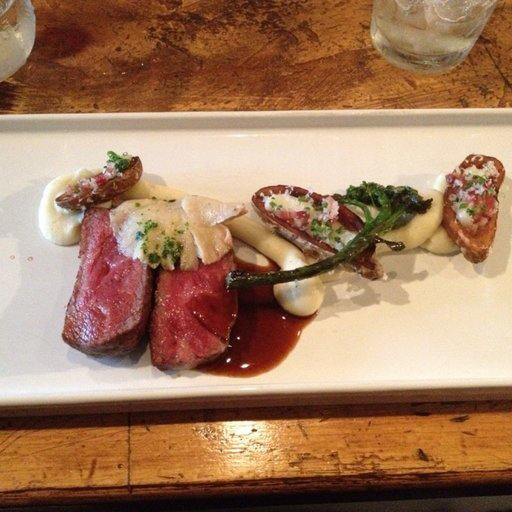

In [85]:
import random
from PIL import Image

# Set seed
#random.seed(42)

# 1. Get all of the image paths
image_path_list = list(image_path.glob('*/*/*.jpg')) # groovy glob!

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get the image class from path name
image_class = random_image_path.parent.stem
print(image_class)

# 4. open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f'Random image path: {random_image_path}')
print(f'Image class: {image_class}')
print(f'Image height: {img.height}')
print(f'Image width: {img.width}')
img

In [86]:
# Visualize with matplotlib...

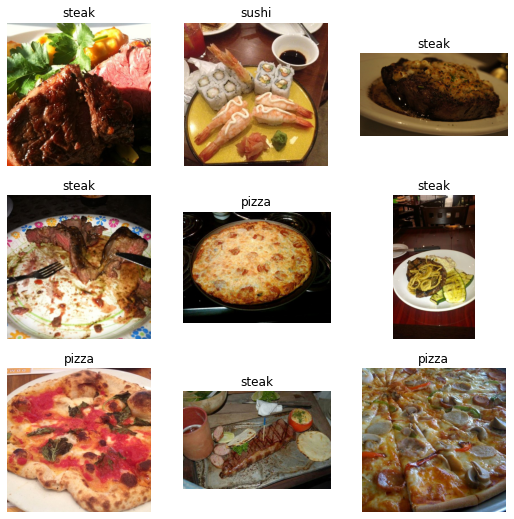

In [87]:
import matplotlib.pyplot as plt

rows, cols = 3, 3
fig = plt.figure(figsize=(9,9))
for i in range(1, rows*cols + 1):
  random_image_path = random.choice(image_path_list)
  # 3. Get the image class from path name
  label = random_image_path.parent.stem
  random_img = Image.open(random_image_path)
  fig.add_subplot(rows, cols, i)
  plt.imshow(random_img)
  plt.title(label)
  plt.axis(False)

(-0.5, 511.5, 511.5, -0.5)

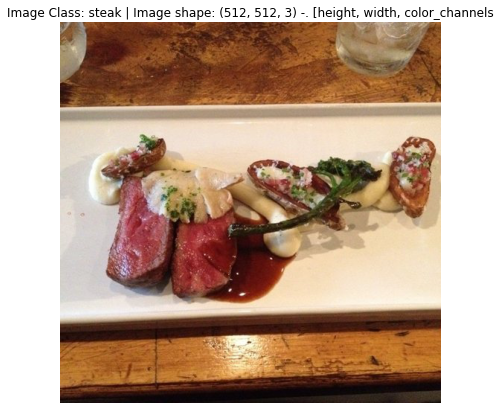

In [88]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with motplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f'Image Class: {image_class} | Image shape: {img_as_array.shape} -. [height, width, color_channels')
plt.axis(False)

## 3. Transforming data

Want to get data into tensor format:

1. Turn target data into tensors (in our case, numerical representation of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader` to make a batched iterable over the dataset. We'll call these `Dataset` and `DataLoader`.

Many dataset constructors support a `transform` parameter, which we can use for things like moving channels around.

In [89]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

http://pytorch.org/vision/stable/transforms.html

In [90]:
# Write a transform for image
data_transform = transforms.Compose([ # can also use nn.Sequential
  # Resize image to 64x64                                   
  transforms.Resize(size=(64, 64)),
  # Flip the images randomly on horizontal
  transforms.RandomHorizontalFlip(p=0.5),
  # Turn the image into a tensor
  transforms.ToTensor() # converts rgb to 0.0-1.0 values
])

In [91]:
transformed = data_transform(img)
transformed.shape

torch.Size([3, 64, 64])

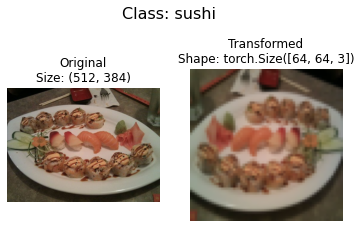

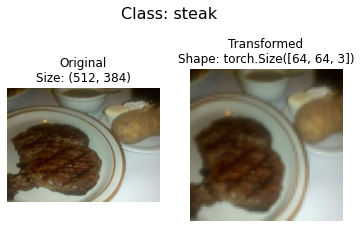

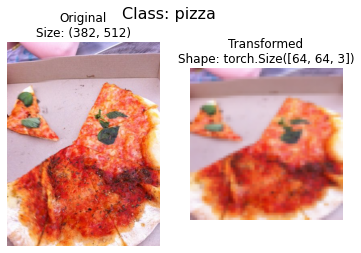

In [92]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """
  Selects random images from a path of images then loads/transforms them
  then plots the original vs. the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f'Original\nSize: {f.size}')
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # specifies new axes order
      ax[1].imshow(transformed_image)
      ax[1].set_title(f'Transformed\nShape: {transformed_image.shape}')
      ax[1].axis('off') # same as False

      fig.suptitle(f'Class: {image_path.parent.stem}', fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3)

## 4. Option 1: Loading image data using ImageFolder

We can load image classification data using `torchvision.datasets.ImageFolder`

In [93]:
# Use ImageFolder to create datasets
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, 
                                  transform=data_transform, # transform for the data
                                  target_transform=None) # transform for the labels

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data                                 

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ), Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [94]:
# Class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [95]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [96]:
# Check the lengths of our dataset
len(train_data), len(test_data)

(225, 75)

In [97]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [98]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f'Image Tensor:\n{img}')
print(f'Image shape: {img.shape}')
print(f'Image datatype: {img.dtype}')
print(f'label:{label}')
print(f'label type: {type(label)}')

Image Tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0863],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0706],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

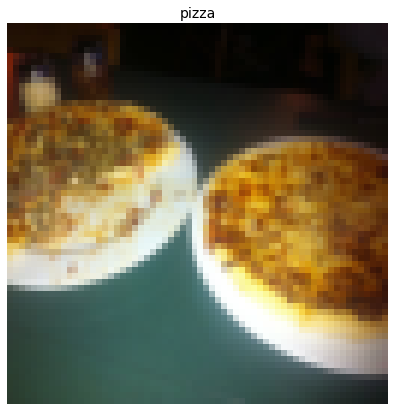

In [99]:
# Rearrange order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f'Original shape: {img.shape} -> [color_channels, height, width]')
print(f'Image permute: {img_permute.shape} -> [height, width, color_channels]')

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis('off')
plt.title(class_names[label], fontsize=14)

### 4.1 Turn loaded images into `DataLoader`s

A `DataLoader` turns our `Dataset`s into iterables and we can customize the `batch_size` so our model can see `batch_size` images at a time.

In [100]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [101]:
import os
os.cpu_count()

2

In [102]:
# Turn and train and test datasets into DataLoaders
from torch.utils.data import DataLoader


BATCH_SIZE= 1
train_dataloader = DataLoader(dataset=train_data,
                               batch_size=BATCH_SIZE,
                               num_workers=os.cpu_count(),
                               shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f5ddb176f10>,
 <torch.utils.data.dataloader.DataLoader at 0x7f5ddb176b20>)

In [103]:
img, label = next(iter(train_dataloader))

# Batch size is 1, but you can change it
print(f'Image shape: {img.shape} -> [batch_size, cholor_channels, height, width]')
print(f'Label shape: {label.shape}')

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, cholor_channels, height, width]
Label shape: torch.Size([1])


## 5 Option 2: Loading Image Data with a Custom `Dataset`

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros: 
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-build `Dataset` functions

Cons:
* Even though you could create a Dataset, it doesn't mean it will work
* Using a custom `Dataset` results in more code (with attendent performance/bugs to be worked out)

Custom `Dataset`s in PyTorch subclass `torch.utils.data.Dataset`

In [104]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset

from torchvision import transforms
from typing import Tuple, Dict, List

In [105]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We want a function to:

1. Get the class names using `os.scandir()` to traverse a target directory (ideally in standard image classification format).
2. Raise an error if the class names aren't found (if this happens there might be something wrong with the directory structure)
3. Turn the class names into a dict and a list and return them

In [106]:
# Setup path for target directory
target_directory = train_dir
print(f'Target dir: {target_directory}')

# get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [107]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """
  Finds the class folder names in a target directory.
  """
  classes = sorted([entry.name for entry in os.scandir(directory) if entry.is_dir()])

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}, please check file structure")

  # 3. Create a dictionadex labels
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [108]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
  * paths - paths of our images
  * transform - the transform we'd like to use
  * classes - a list of the target classes
  * class_to_idx - a dict of target classes mapped to integer labels
4. Create a function to `load_images()`
5. Override a `__len()__` method
6. Override the `__getitem()__` method to return a given sample when passed an index.

In [109]:
# Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize our custom dataset
  def __init__(self, 
               targ_dir: str,
               transform=None):
    # 3. Create classs attributes
    super().__init__()
    self.paths = list(pathlib.Path(targ_dir).glob('*/*.jpg'))
    # Setup transforms:
    self.transform = transform
    # create classes and class_to_idx
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Function to load images
  def load_image(self, index: int) -> Image.Image:
    """opens an image via a path and returns it"""
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Override __len__ to return length of dataset
  def __len__(self) -> int:
    """Returns the total number of samples."""
    return len(self.paths)
  
  # 6. Override __get_item()__
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and label (X, y)."
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary:
    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx

In [110]:
# Create train and test transforms
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()    
])

In [111]:
# Test out ImageFolderCustom

train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transform)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transform)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7f5ddb15bd90>,
 <__main__.ImageFolderCustom at 0x7f5ddb15b910>)

In [112]:
len(train_data), len(train_data_custom)

(225, 225)

In [113]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

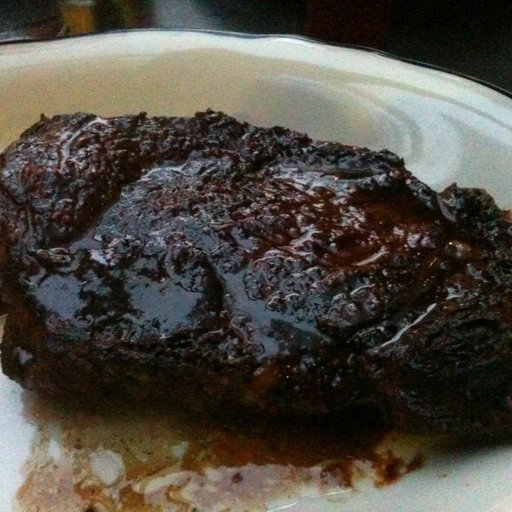

In [114]:
train_data_custom.load_image(1)

In [115]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [116]:
# checkfor equality between the two datasets
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True


### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproducibility
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot.
6. Loop through the random sample images and plot them with matplotlib.
7. Make sure the dimensions of our images line up with matplotlib (HWC)

In [117]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2. Prevent the display from getting out of hand, cap the number of images
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display")

  # 3. set seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # 5. Setup plot
  plt.figure(figsize=(16, 8))

  # 6. Loop through indices and plot with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Make sure the dimensions line up:
    targ_image_adjust = targ_image.permute(1, 2, 0) # channels last

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis('off')
    if classes:
      title = f'Class: {classes[targ_label]}'
      if display_shape:
        title = title + f'\nshape: {targ_image_adjust.shape}'
      plt.title(title)


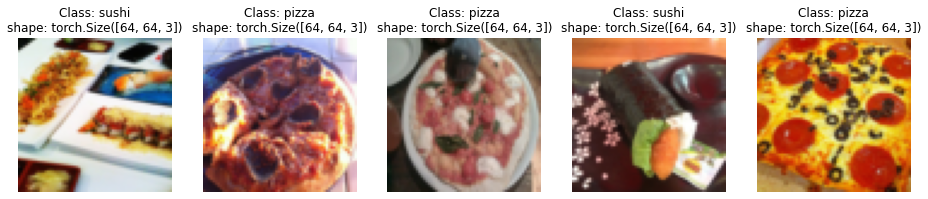

In [118]:
# display random images from the ImageFolder created dataset:
display_random_images(train_data, n=5, classes=class_names, seed=42)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display


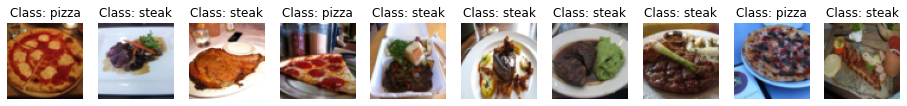

In [119]:
# display random images from the ImageFolderCustom created dataset:
display_random_images(train_data_custom, n=20, classes=class_names, seed=42)

In [120]:
### 5.4 Turn custom loaded images into `DataLoader`s

In [121]:
from torch.utils.data import DataLoader
import os

BATCH_SIZE=32
NUM_WORKERS=os.cpu_count()

train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS)
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7f5ddb1b5040>,
 <torch.utils.data.dataloader.DataLoader at 0x7f5dd9e48eb0>)

In [122]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))
img_custom.shape, label_custom

(torch.Size([32, 3, 64, 64]),
 tensor([1, 2, 2, 2, 0, 2, 1, 1, 2, 1, 1, 2, 0, 2, 0, 1, 2, 0, 0, 2, 1, 0, 2, 2,
         1, 0, 0, 1, 2, 2, 2, 1]))

## 6. Other forms of transforms (data augmentation)

Data augmentation is the process of artificially adding diversity to your training data.

In the case of image data, this may mean applying various image transformations to the training images.

This practice hopefully results in a better-generalized model.

Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art levels.

Blog post: https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

In [123]:
# Let's look at trivial augment
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # max intensity (32)
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])



In [124]:
# Get all the image paths
image_path_list = list(image_path.glob('*/*/*.jpg'))
image_path_list[:3]

[PosixPath('data/pizza_steak_sushi/test/steak/1868005.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/690177.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1302563.jpg')]

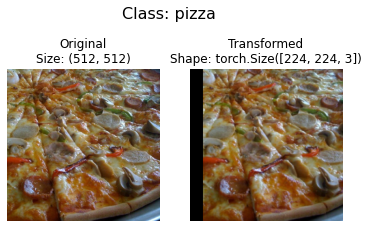

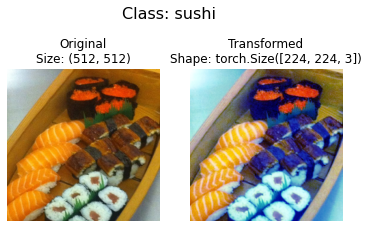

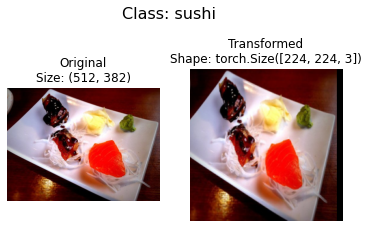

In [125]:
# Plot random transformed images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

## 7. Model 0: TinyVGG without data augmentation

Let's replicate TinyVGG architecture from the CNN explainer site.

### 7.1 Creating transforms and loading data for Model 0

In [126]:
from torchvision import transforms

# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [127]:
from torchvision.datasets import ImageFolder

train_data_simple = ImageFolder(root=train_dir,
                                transform=simple_transform)

test_data_simple = ImageFolder(root=test_dir,
                               transform=simple_transform)

train_data_simple, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ), Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ))

In [128]:
from torch.utils.data import DataLoader
import os

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

train_dataloader_simple, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x7f5dd9e64190>,
 <torch.utils.data.dataloader.DataLoader at 0x7f5dd9e64d90>)

In [129]:
from torch import nn
from collections import OrderedDict

class DebugLayer(nn.Identity):
  def __init__(self, name, debug):
    super().__init__()
    self.name = name
    self.debug = debug if debug else [False]

  def forward(self, x):
    if self.debug[0]:
      print(f'Layer {self}:{self.name} received {x.shape}')
    return super().forward(x)


def make_conv_layer(hidden_units: int,
                    input_shape: int=None,
                    output_shape: int=None,
                    name: str='',
                    use_dropout=False,
                    debug=None,
                    padding=1) -> nn.Module:
  KERNEL_SIZE = 3
  if input_shape is None:
    input_shape = hidden_units
  if output_shape is None:
    output_shape = hidden_units
  return nn.Sequential(
      DebugLayer(name, debug),
      nn.Conv2d(in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=KERNEL_SIZE,
                stride=1,
                padding=padding),
      nn.ReLU(),
      nn.Dropout() if use_dropout else nn.Identity(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=KERNEL_SIZE,
                stride=1,
                padding=padding),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2,
                   stride=2)) # default stride is same as kernel_size

class TinyVGGModelV0(nn.Module):  
  def __init__(self, 
               input_shape: int, 
               output_shape: int, 
               hidden_units: int, 
               input_dim=1,
               use_dropout=False,
               device=device,
               cnn_block_count=1,
               padding: int=1):
    super().__init__()
    CLASSIFIER_KERNEL_SIZE = 2
    self.debug=[True]
    cnn_blocks = OrderedDict()
    cnn_blocks['base'] = make_conv_layer(input_shape=input_shape, 
                                         hidden_units=hidden_units,
                                         name='base',
                                         debug=self.debug,
                                         padding=padding)
    for block_index in range(cnn_block_count):
      name = f'cnn{block_index}'
      cnn_blocks[name] = make_conv_layer(hidden_units, 
                                         name=name, 
                                         use_dropout=use_dropout, 
                                         debug=self.debug,
                                         padding=padding)

    classifier_input_features = int(input_dim / ((2 ** cnn_block_count) * CLASSIFIER_KERNEL_SIZE))
    padding_offset = 0
    linear_input_features = hidden_units * ((classifier_input_features - padding_offset) ** 2)
    print(f'padding_offset={padding_offset}, classifier_input_features={classifier_input_features}, linear_input_features={linear_input_features}')
    cnn_blocks['classifier'] = nn.Sequential(
        DebugLayer(name='classifier', debug=self.debug),
        nn.Flatten(),
        nn.Linear(in_features=linear_input_features,
                  out_features=output_shape)
    )

    self.cnn_blocks = nn.Sequential(cnn_blocks)

  def set_debug(self, debug: bool):
    self.debug[0] = debug

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.cnn_blocks(x)
     

In [130]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
HIDDEN_UNITS = 10

model_0 = TinyVGGModelV0(input_shape=3, # color channels in image
                         output_shape=3,
                         input_dim=64, # 64x64 images
                         hidden_units=10,
                         device=device,
                         padding=1, # SHOULD BE 0
                         cnn_block_count=1).to(device)
sample_image_batch = next(iter(train_dataloader_simple))[0].to(device)
model_0(sample_image_batch)

padding_offset=0, classifier_input_features=16, linear_input_features=5120
Layer DebugLayer():base received torch.Size([32, 3, 64, 64])
Layer DebugLayer():cnn0 received torch.Size([32, 20, 32, 32])
Layer DebugLayer():classifier received torch.Size([32, 20, 16, 16])


tensor([[ 0.0139, -0.0107,  0.0160],
        [ 0.0117, -0.0115,  0.0108],
        [ 0.0125, -0.0090,  0.0176],
        [ 0.0156, -0.0106,  0.0189],
        [ 0.0152, -0.0134,  0.0185],
        [ 0.0115, -0.0115,  0.0121],
        [ 0.0152, -0.0086,  0.0169],
        [ 0.0130, -0.0112,  0.0174],
        [ 0.0135, -0.0081,  0.0138],
        [ 0.0151, -0.0082,  0.0097],
        [ 0.0134, -0.0119,  0.0145],
        [ 0.0161, -0.0144,  0.0147],
        [ 0.0146, -0.0062,  0.0164],
        [ 0.0158, -0.0106,  0.0151],
        [ 0.0146, -0.0076,  0.0163],
        [ 0.0149, -0.0097,  0.0166],
        [ 0.0166, -0.0100,  0.0135],
        [ 0.0128, -0.0108,  0.0177],
        [ 0.0115, -0.0102,  0.0093],
        [ 0.0190, -0.0116,  0.0126],
        [ 0.0161, -0.0112,  0.0170],
        [ 0.0182, -0.0108,  0.0186],
        [ 0.0125, -0.0061,  0.0104],
        [ 0.0124, -0.0092,  0.0157],
        [ 0.0141, -0.0091,  0.0169],
        [ 0.0122, -0.0080,  0.0144],
        [ 0.0192, -0.0089,  0.0170],
 

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [131]:
# Install torchinfo, import it if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])

Layer DebugLayer():base received torch.Size([1, 3, 64, 64])
Layer DebugLayer():cnn0 received torch.Size([1, 20, 32, 32])
Layer DebugLayer():classifier received torch.Size([1, 20, 16, 16])


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGGModelV0                           [1, 3]                    --
├─Sequential: 1-1                        [1, 3]                    --
│    └─Sequential: 2-1                   [1, 20, 32, 32]           --
│    │    └─DebugLayer: 3-1              [1, 3, 64, 64]            --
│    │    └─Conv2d: 3-2                  [1, 20, 64, 64]           560
│    │    └─ReLU: 3-3                    [1, 20, 64, 64]           --
│    │    └─Identity: 3-4                [1, 20, 64, 64]           --
│    │    └─Conv2d: 3-5                  [1, 20, 64, 64]           3,620
│    │    └─ReLU: 3-6                    [1, 20, 64, 64]           --
│    │    └─MaxPool2d: 3-7               [1, 20, 32, 32]           --
│    └─Sequential: 2-2                   [1, 20, 16, 16]           --
│    │    └─DebugLayer: 3-8              [1, 20, 32, 32]           --
│    │    └─Conv2d: 3-9                  [1, 20, 32, 32]           3,620
│    │  

### 7.5 Create train and test loop functions

* `train_step()` - takes in a model and dataloader and trains the model on the dataloader
* `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader

In [132]:
# Create train_step()

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
  # put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through dataloader batches
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. optimiizer zero grad
    optimizer.zero_grad()

    # 4. back prop
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item() / len(y_pred)

  # Adjust metrics to get average loss/accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [133]:
# Create a test_step function
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  # Put model in eval mode
  model.eval()

  test_loss, test_acc = 0, 0

  with torch.inference_mode():
    # Loop through dataloader batches
    for batch, (X, y) in enumerate(dataloader):
      # send data to device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)
      # 2. Calculate loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate the accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1) # same as with softmax
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)

  return test_loss, test_acc

### 7.6 Combine train and test step function

In [134]:
from tqdm.auto import tqdm

# 1. Create a train function that takes a buncha stuff

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):
  # 2. Create empty results dictionary
  results = {'train_loss': [],
             'train_acc': [],
             'test_loss': [],
             'test_acc': []}

  # 3. Loop through training and testing steps
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)
    # 4. Print out what's happening
    if epochs < 10 or (epoch % int(epochs / 10) == 0):
      print(f'Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}')
    # 5. Update results dictionary
    results['train_loss'].append(train_loss)
    results['test_loss'].append(test_loss)
    results['train_acc'].append(train_acc)
    results['test_acc'].append(test_acc)

  # 6. outside loop, return results
  return results


### 7.7. Train and evaluate model 0

In [135]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS=5

loss_fn = nn.CrossEntropyLoss()
optimizer_model_0 = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

model_0.set_debug(False)

# start the timer
from timeit import default_timer as timer
start_time = timer()
model_0_results = train(
      model=model_0,
      train_dataloader=train_dataloader_simple,
      test_dataloader=test_dataloader_simple,
      optimizer=optimizer_model_0,
      loss_fn=loss_fn,
      epochs=NUM_EPOCHS)

# end the timer and print how long it took
end_time = timer()
print(f'Total training time: {end_time - start_time:.3f} seconds')


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1038 | Train acc: 0.2578 | Test loss: 1.0949 | Test acc: 0.3021
Epoch: 5 | Train loss: 0.9345 | Train acc: 0.5898 | Test loss: 0.9458 | Test acc: 0.5152
Epoch: 10 | Train loss: 0.7841 | Train acc: 0.6797 | Test loss: 1.0258 | Test acc: 0.3826
Epoch: 15 | Train loss: 0.7238 | Train acc: 0.7031 | Test loss: 0.9720 | Test acc: 0.4640
Epoch: 20 | Train loss: 0.5183 | Train acc: 0.8125 | Test loss: 1.3230 | Test acc: 0.4242
Epoch: 25 | Train loss: 0.4760 | Train acc: 0.8125 | Test loss: 1.2135 | Test acc: 0.4848
Epoch: 30 | Train loss: 0.2538 | Train acc: 0.9023 | Test loss: 1.5989 | Test acc: 0.4763
Epoch: 35 | Train loss: 0.6487 | Train acc: 0.6914 | Test loss: 1.9628 | Test acc: 0.3939
Epoch: 40 | Train loss: 0.2280 | Train acc: 0.9453 | Test loss: 1.4946 | Test acc: 0.4754
Epoch: 45 | Train loss: 0.0761 | Train acc: 0.9961 | Test loss: 2.1742 | Test acc: 0.4555
Total training time: 151.602 seconds


### 7.7a - Double-check against the official model

In [136]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        # x = self.conv_block_1(x)
        # # print(x.shape)
        # x = self.conv_block_2(x)
        # # print(x.shape)
        # x = self.classifier(x)
        # # print(x.shape)
        # return x
        return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0_a = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                    hidden_units=HIDDEN_UNITS, 
                    output_shape=len(train_data.classes)).to(device)
model_0_a

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=5120, out_features=3, bias=True)
  )
)

In [137]:
optimizer_0_a = torch.optim.Adam(params=model_0_a.parameters(), lr=0.001)
# start the timer
from timeit import default_timer as timer
start_time = timer()
model_0_a_results = train(
      model=model_0_a,
      train_dataloader=train_dataloader_simple,
      test_dataloader=test_dataloader_simple,
      optimizer=optimizer_0_a,
      loss_fn=loss_fn,
      epochs=NUM_EPOCHS)

# end the timer and print how long it took
end_time = timer()
print(f'Total training time: {end_time - start_time:.3f} seconds')


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1073 | Train acc: 0.4180 | Test loss: 1.1074 | Test acc: 0.2604
Epoch: 5 | Train loss: 1.0308 | Train acc: 0.5547 | Test loss: 1.1235 | Test acc: 0.3229
Epoch: 10 | Train loss: 0.8790 | Train acc: 0.5977 | Test loss: 1.1064 | Test acc: 0.3731
Epoch: 15 | Train loss: 0.7508 | Train acc: 0.6797 | Test loss: 1.0351 | Test acc: 0.4432
Epoch: 20 | Train loss: 0.7043 | Train acc: 0.7383 | Test loss: 0.9643 | Test acc: 0.5653
Epoch: 25 | Train loss: 0.5959 | Train acc: 0.7695 | Test loss: 1.0750 | Test acc: 0.5265
Epoch: 30 | Train loss: 0.8366 | Train acc: 0.6367 | Test loss: 1.1601 | Test acc: 0.3324
Epoch: 35 | Train loss: 0.5256 | Train acc: 0.7383 | Test loss: 1.5399 | Test acc: 0.3731
Epoch: 40 | Train loss: 0.2786 | Train acc: 0.9023 | Test loss: 1.7959 | Test acc: 0.3826
Epoch: 45 | Train loss: 0.2289 | Train acc: 0.9297 | Test loss: 1.9793 | Test acc: 0.4347
Total training time: 183.348 seconds


### 7.8 Plot Model 0 Results as a Loss Curve

A **loss curve** is a way of tracking your model's progress over time.

A good guide for different loss curves: https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic

In [138]:
# model_0 results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [139]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots training curves of a results dictionary."""
  # Get the loss values of the results dictionary (training and test)
  loss = results['train_loss']
  test_loss = results['test_loss']

  # Get the accuracy values
  accuracy = results['train_acc']
  test_accuracy = results['test_acc']

  # How many epochs?
  epochs = range(len(loss))

  # Setup a plot
  plt.figure(figsize=(15, 7))

  # Plot loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label='train_loss')
  plt.plot(epochs, test_loss, label='test_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label='train_accuracy')
  plt.plot(epochs, test_accuracy, label='test_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()


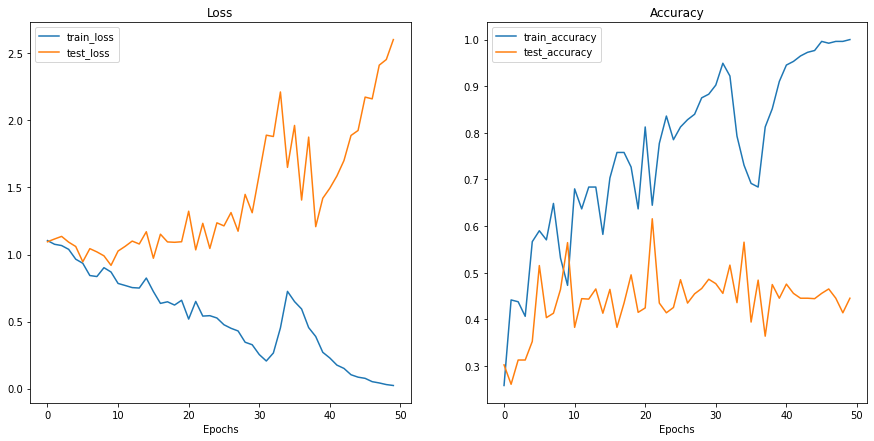

In [140]:
plot_loss_curves(model_0_results)

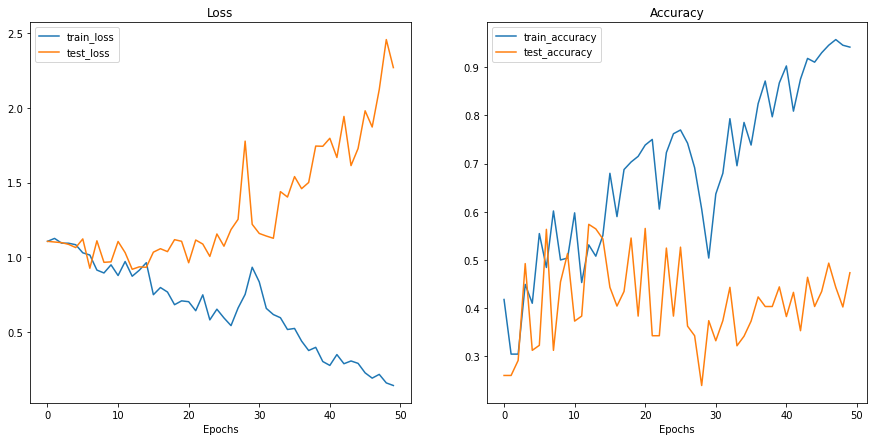

In [141]:
plot_loss_curves(model_0_a_results)

### 8. What should an ideal loss curve look like?

Not like these! You want both train and test loss to go down without much difference between them.

## 9. Model 1: TinyVGG with Data Augmentation

Now let's try another modelling experiment, this time using the same model as before but with some data augmentation.

### 9.1 Create transform with Data Augmentation

In [142]:
# Create training transform with TrivialAugment
from torchvision import transforms
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

### 9.2 Create train and test `Dataset`s and `Dataloader`s with data augmentation

In [143]:
# Turn image folders into Datasets
from torchvision import datasets

train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=test_transform_simple)

In [144]:
# Turn datasets into dataloaders
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)


In [149]:
# construct and train model_1
model_1 = TinyVGG(input_shape=3, hidden_units=10, output_shape=3).to(device)

model_1_optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# start the timer
from timeit import default_timer as timer
start_time = timer()
model_1_results = train(
      model=model_1,
      train_dataloader=train_dataloader_augmented,
      test_dataloader=test_dataloader_simple,
      optimizer=model_1_optimizer,
      loss_fn=loss_fn,
      epochs=NUM_EPOCHS)

# end the timer and print how long it took
end_time = timer()
print(f'Total training time: {end_time - start_time:.3f} seconds')

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.0994 | Train acc: 0.3594 | Test loss: 1.1027 | Test acc: 0.2604
Epoch: 5 | Train loss: 1.0911 | Train acc: 0.3828 | Test loss: 1.1532 | Test acc: 0.2604
Epoch: 10 | Train loss: 1.0898 | Train acc: 0.4219 | Test loss: 1.1024 | Test acc: 0.2282
Epoch: 15 | Train loss: 1.0806 | Train acc: 0.4727 | Test loss: 1.1154 | Test acc: 0.3419
Epoch: 20 | Train loss: 0.9607 | Train acc: 0.5273 | Test loss: 0.9275 | Test acc: 0.5331
Epoch: 25 | Train loss: 0.9923 | Train acc: 0.5898 | Test loss: 1.0160 | Test acc: 0.4441
Epoch: 30 | Train loss: 0.9342 | Train acc: 0.5195 | Test loss: 0.9416 | Test acc: 0.4839
Epoch: 35 | Train loss: 0.8138 | Train acc: 0.6562 | Test loss: 0.9439 | Test acc: 0.5237
Epoch: 40 | Train loss: 0.8846 | Train acc: 0.6328 | Test loss: 1.1593 | Test acc: 0.3324
Epoch: 45 | Train loss: 1.0159 | Train acc: 0.5195 | Test loss: 1.0662 | Test acc: 0.3939
Total training time: 127.719 seconds


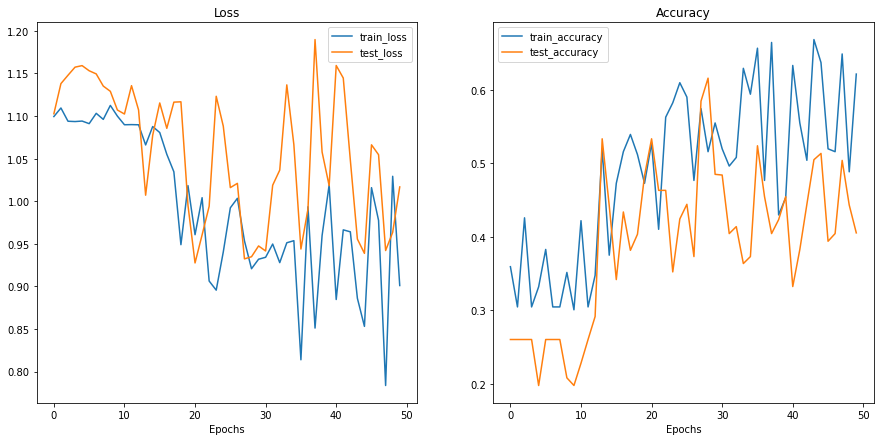

In [150]:
plot_loss_curves(model_1_results)

## 10. Compare model results

* Code
* PyTorch and Tensorboard
* Weights & Biases
* MLFlow - https://mlflow.org/

In [151]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_1_df

,train_loss,train_acc,test_loss,test_acc
0,1.099410,0.359375,1.102680,0.260417
1,1.109460,0.304688,1.138089,0.260417
2,1.093894,0.425781,1.147900,0.260417
3,1.093531,0.304688,1.157402,0.260417
4,1.094100,0.332031,1.159207,0.197917
5,1.091076,0.382812,1.153165,0.260417
6,1.103173,0.304688,1.149473,0.260417
7,1.096093,0.304688,1.135181,0.260417
8,1.112487,0.351562,1.129039,0.208333
9,1.099914,0.300781,1.107088,0.197917


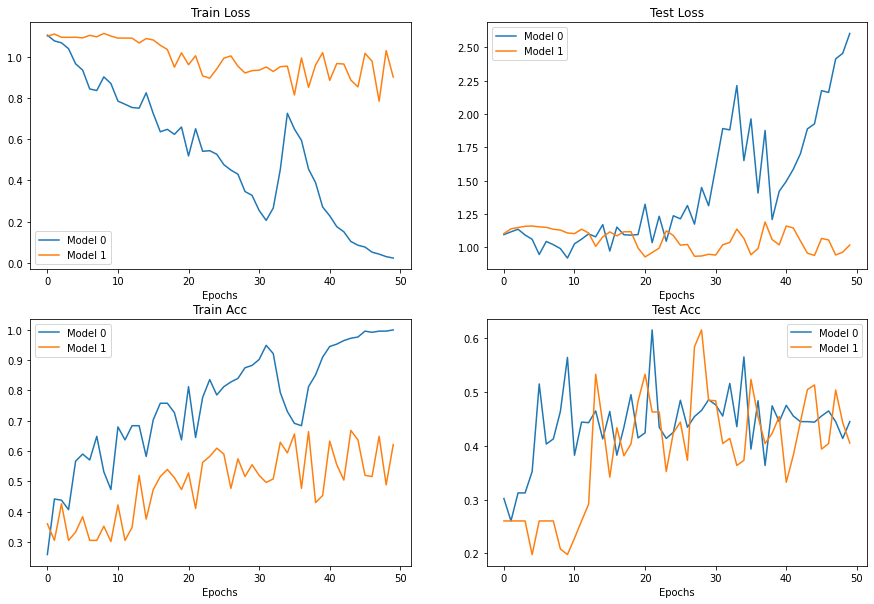

In [152]:
# Plot model_1 and model_0 on same plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot the train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df['train_loss'], label='Model 0')
plt.plot(epochs, model_1_df['train_loss'], label='Model 1')
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot the test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df['test_loss'], label='Model 0')
plt.plot(epochs, model_1_df['test_loss'], label='Model 1')
plt.title('Test Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df['train_acc'], label='Model 0')
plt.plot(epochs, model_1_df['train_acc'], label='Model 1')
plt.title('Train Acc')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df['test_acc'], label='Model 0')
plt.plot(epochs, model_1_df['test_acc'], label='Model 1')
plt.title('Test Acc')
plt.xlabel('Epochs')
plt.legend()

### 11. Making a prediction on a custom image

Although we've trained a model on custom data, how do you make a prediction on a sample image that's not in either training or testing dataset?

In [155]:
# Download a custom image
import requests

# Setup custom image path
custom_image_path = data_path / '04-pizza-dad.jpeg'

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
  with open(custom_image_path, 'wb') as f:
    # When downloading an image from GitHub, need to use the raw file link:
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/04-pizza-dad.jpeg')
    print(f'Downloading {custom_image_path}...')
    f.write(request.content)
else:
  print(f'{custom_image_path} already exists, skipping download')

### 11.1 Loading in a custom image with PyTorch

We have to make sure our custom image is in the same format our model was trained on.

* In tensor form with datatype (torch.float32)
* Of shape 64x64x3
* On the right device

In [163]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
print(f'custom_image_uint8.shape: {custom_image_uint8.shape}, custom_image_uint8.device: {custom_image_uint8.device}, datatype: {custom_image_uint8.dtype}')

custom_image_uint8.shape: torch.Size([3, 4032, 3024]), custom_image_uint8.device: cpu, datatype: torch.uint8


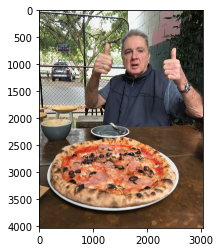

In [158]:
plt.imshow(custom_image_uint8.permute(1, 2, 0))

### 11.2 Making a prediction on a custom image with a trained PyTorch model

In [166]:
# Try to make a prediction on an image
model_1.eval()
with torch.inference_mode():
  # this will fail, so need to convert to Float32
  # model_1(custom_image_uint8.to(device))
  pass

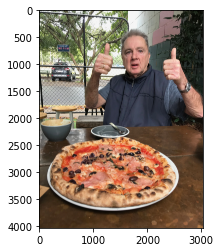

In [170]:
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255. # scale pixel integers to 0-1
plt.imshow(custom_image.permute(1, 2, 0))

In [169]:
model_1.eval()
with torch.inference_mode():
  # model_1(custom_image.to(device)) # will also fail because image size is still too big
  pass

In [173]:
# Create a transform pipeline to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64, 64))
])

# Transform target image:
custom_image_transformed = custom_image_transform(custom_image)
print(f'Original shape: {custom_image.shape}, Transformed: {custom_image_transformed.shape}')

Original shape: torch.Size([3, 4032, 3024]), Transformed: torch.Size([3, 64, 64])


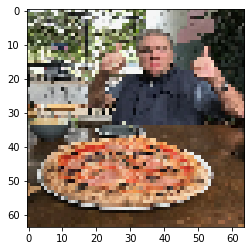

In [174]:
plt.imshow(custom_image_transformed.permute(1, 2, 0))

In [176]:
model_1.eval()
with torch.inference_mode():
  # Error, no batch size:
  # custom_image_pred = model_1(custom_image_transformed.to(device))
  pass

In [189]:
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))
class_names[custom_image_pred.argmax().cpu()]

'pizza'

Note, to make a prediction on a custom image we had to:
* Load the image and turn it into a tensor
* Make sure the image was the same datatype as the model (torch.float32)
* Make sure the image was the same shape as the data the model was trained on (3, 64, 64) with a batch size (1, 3, 64, 64)
* Make sure the image was on the same device as the model

In [186]:
# Convert logits to prediction probabilities
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.4881, 0.2507, 0.2613]])

In [190]:
# Convert prediction probabilities to prediction labels
custom_image_pred_labels = torch.argmax(custom_image_pred_probs, dim=1)
custom_image_pred_labels

tensor([0])

### 11.3 Putting custom image prediction together: building a function

Ideal outcome:

A function where we pass an image path to and have our model predict on that image and plot an image + prediction.

In [199]:
class_names

['pizza', 'steak', 'sushi']

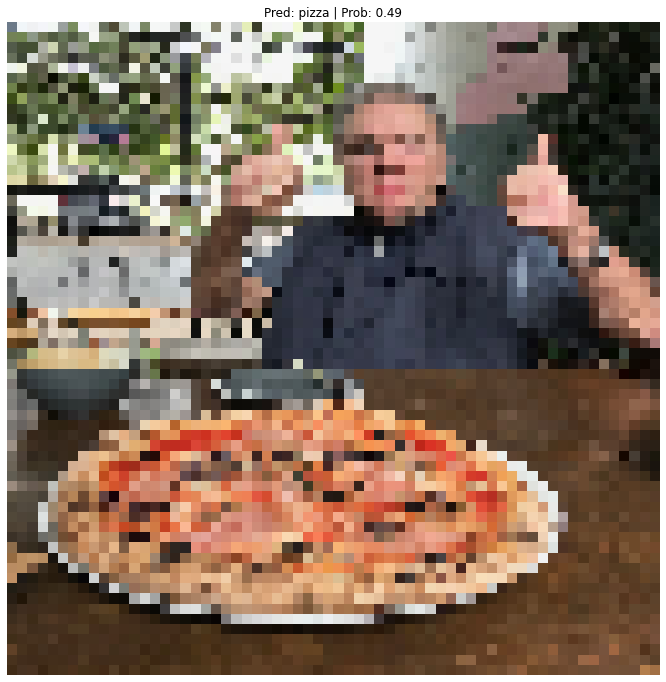

In [212]:
import torchvision
import matplotlib.pyplot as plt

def predict_image(model: nn.Module,
                  image_path: str,                  
                  class_names: List[str]=None,
                  transform: nn.Module=None,
                  device=device) -> str:
  """Makes a prediction on a target image with a trained model and plots the image and prediction"""
  # load and convert the image
  # Read in custom image
  custom_image = torchvision.io.read_image(image_path).type(torch.float32) / 255.
  if transform:
    custom_image = transform(custom_image)

  # make the prediction
  model.to(device)
  model.eval()
  with torch.inference_mode():
    # adds batch dim, puts on device, gets the argmax
    target_image_pred = model(custom_image.unsqueeze(0).to(device))
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    custom_image_label = torch.argmax(target_image_pred_probs, dim=1)

  # plot the prediction
  plt.figure(figsize=(12, 12))
  plt.imshow(custom_image.permute(1, 2, 0))
  if class_names:
    title = f'Pred: {class_names[custom_image_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.2f}'
  else:
    title = f'Pred: {custom_image_label.cpu()} | Prob: {target_image_pred_probs.max().cpu():.2f}'
  plt.title(title)
  plt.axis(False)


predict_image(model=model_1,
              image_path=str(custom_image_path), 
              class_names=class_names,
              transform=transforms.Resize(size=(64, 64)),
              device=device)